In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instruction on using Jupter notebooks, see the [README.MD](../../README.MD) file. 

This notebook demonstrates how to combine data from multiple sources in an algorithm. 

# Combining Data from Multiple Data Sources in an Algorithm
* Make sure you have PODPAC properly installed WITH the **datatype** and **algorithms** optional dependencies: `pip install podpac[datatype]` `pip install podpac[algorithms]`

## Creating `DataSource` nodes
See the [open-raster-file.ipynb](open-raster-file.ipynb) for more details opening these files. 

In [2]:
import podpac
# We also need traitlets to tell PODPAC about our algorithm inputs
import traitlets as tl  

In [3]:
# Elevation file
srtm = podpac.data.Rasterio(source='../../data/raster/n39_w107_1arc_v2.tif')
srtm.native_coordinates

D:\PODPAC_INSTALL\podpac\podpac\core\data\datasource.py:170: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  self.native_coordinates = self.get_native_coordinates()
D:\PODPAC_INSTALL\podpac\podpac\core\data\datasource.py:170: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  self.native_coordinates = self.get_native_coordinates()


Coordinates
	lat: UniformCoordinates1d(lat): Bounds[38.99986111111111, 40.000138888888884], N[3601], ctype['midpoint']
	lon: UniformCoordinates1d(lon): Bounds[-107.00013888888888, -105.9998611111111], N[3601], ctype['midpoint']

In [4]:
# Define a new class, inheriting from the PODPAC H5PY class
class SMAPH5(podpac.data.H5PY):
    datakey = '/Analysis_Data/sm_surface_analysis'
    # Overwrite the 'get_native_coordinates' function to tell PODPAC what coordinates that data uses
    def get_native_coordinates(self):
        lat = self.dataset['cell_lat'][:, 0]
        lon = self.dataset['cell_lon'][0, :]
        # the order is important. lat = rows of array. lon = cols of array
        # return podpac.Coordinates([lon, lat], dims=['lon', 'lat'])  # <--- This is the WRONG order
        return podpac.Coordinates([lat, lon], dims=['lat', 'lon'])
# SMAP file
smap = SMAPH5(source='../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5',
              nan_vals=[-9999],
              interpolation='bilinear')
smap.native_coordinates

Coordinates
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.9533233642578, 179.9533233642578], N[3856], ctype['midpoint']

## Creating Algorithm Node

In [5]:
# Create a new class, inhereting from Algorithm node
class WetElevation(podpac.algorithm.Algorithm):
    # Define the inputs as PODPAC nodes
    elevation = tl.Instance(podpac.Node)
    soil_moisture = tl.Instance(podpac.Node)
    
    # Define the algorithm
    def algorithm(self, inputs):
        # See if wetter soil_moisture is found at lower elevation
        median_sm = inputs['soil_moisture'].median()
        median_elev = inputs['elevation'].median()
        
        return (inputs['soil_moisture'] > median_sm) & (inputs['elevation'] <= median_elev)

## Evaluation Algorithm

In [6]:
# Make in instance of the algorithm
wet_elevation = WetElevation(elevation=srtm, soil_moisture=smap)

# Create coordinates at the elevation's spatial coordinates
coords = srtm.native_coordinates

# Evaluate nodes
o_we = wet_elevation.eval(coords)
o_sm = smap.eval(coords)
o_el = srtm.eval(coords)

## Plotting Results / Analysis

Text(0.5,1,'Algorithm Output')

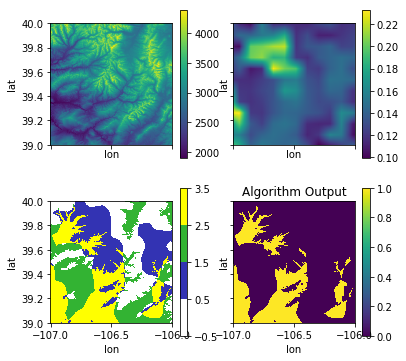

In [7]:
# Make a custom colormap
cmap = cmap = mpl.colors.LinearSegmentedColormap.from_list('namehere', [(1, 1, 1), (0.2, 0.2, 0.7), (0.2, 0.7, 0.2), (1, 1, 0.0)], 4)
norm =  mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Configure the plot
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(6, 6))
plt.setp(axes.flat, aspect=1.0, adjustable='box-forced')

# Plot the data
stride = 4  # Plot every 4th data point in both directions (For speed)
o_el.loc[::stride, ::stride].plot(ax=axes[0, 0])
o_sm.loc[::stride, ::stride].plot(ax=axes[0, 1])
((o_sm > o_sm.median()) + 2 * (o_el <= o_el.mean()))[::stride, ::stride].plot(ax=axes[1, 0], cmap=cmap, norm=norm)
o_we[::stride, ::stride].plot(ax=axes[1, 1]); title('Algorithm Output')

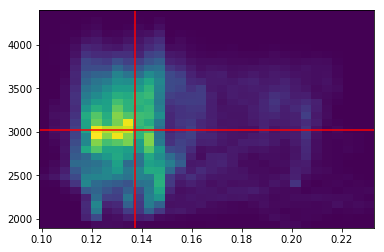

In [8]:
figure()
_ = hist2d(o_sm.data.ravel(), o_el.data.ravel(), bins=32)
plot([o_sm.median(), o_sm.median()], [o_el.min(), o_el.max()], 'r')
plot([o_sm.min(), o_sm.max()], [o_el.median(), o_el.median()], 'r')